# Demo Day!

In [0]:
!pip install fastai2 -q

     |████████████████████████████████| 194kB 6.3MB/s 


In [0]:
import ast
from fastai2.vision.all import *
# from fastai.vision import *
# for scraping for the data
# from pyquery import PyQuery
from urllib.parse import urljoin

## Colab_setup

In [0]:
import os

from pathlib import Path
from google.colab import drive

In [0]:
def create_path(path):
    if not os.path.isdir(path):
        path.mkdir(parents=True, exist_ok=True)
    return path

In [0]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = Path('/content/drive/My Drive')
base_path = create_path(root_dir/'flickr-search')
base_path

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Path('/content/drive/My Drive/flickr-search')

In [0]:
colab_path = Path('/content')

In [0]:
data_path = create_path(base_path/'dataset')

In [0]:
model_path = create_path(base_path/'models')

## Flicker data (Preprocessing/Selecting sample)

https://www.kaggle.com/austinreese/craigslist-carstrucks-data

In [0]:
# urls = "'https://storage.googleapis.com/kaggle-data-sets/62920%2F1026452%2Fcompressed%2Fvehicles.csv.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1590867642&Signature=g2KTzon2B%2F8jdHYeyKPcUXaRDiWrlY5daJ9UHwfB8mFQwMhBR7%2FOvpHg0BllM9EzybvRSZc%2FX9HIIAUmyWUEXZJehohvxgrvzdw9qc%2FQtUi6dUI6JB0IFBVOLOErBj2Tg4T7HiQK56OHbdXK1m6vbW0EfgMPd%2BFb8ZeY1C1nhTFGEap0d7RhsHlz2hBJVOlv8OmHOXGNM%2Fh0pzeH%2FbG9%2BrEMfKNmVlMXfwXphS5SYQLLQvM9hZg%2F1iaYrM9SC7KXNB0wvC%2F67PWWol%2BtH%2F0QHs%2BfosF9mMfLvQFoOo187kiEfXKGdxGhJXsJHTI%2FMRH2mvk6wfr%2F%2FDpf0I6Lv%2BhQjQ%3D%3D'"
# !wget -q {urls} -O 'temp.zip' && unzip -q 'temp.zip' && rm 'temp.zip'

In [0]:
# df = pd.read_csv('/content/vehicles.csv'); df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7088746062,https://greensboro.craigslist.org/ctd/d/cary-2012-acura-tl-base-4dr-sedan/7088746062.html,greensboro,https://greensboro.craigslist.org,10299,2012.0,acura,tl,NaN,NaN,gas,90186.0,clean,automatic,19UUA8F22CA003926,NaN,NaN,other,blue,https://images.craigslist.org/01414_3LIXs9EO33z_600x450.jpg,"2012 Acura TL Base 4dr Sedan Offered by: Best Import Auto Sales Inc — (919) 800-0650 — $10,299 PRISTINE CONDITION INSIDE AND OUT Best Import Auto Sales Inc Year: 2012 Make: Acura Model: TL Series: Base 4dr Sedan VIN: 19UUA8F22CA003926 Condition: Used Mileage: 90,186 Exterior: Blue Interior: Black Body: Sedan Transmission: Automatic 6-Speed Engine: 3.5L V6 **** Best Import Auto Sales Inc. 🚘 Raleigh Auto Dealer ***** ⚡️⚡️⚡️ Call Or Text (919) 800-0650 ⚡️⚡️⚡️ ✅ - We can arrange Financing Options with most banks and credit unions!!!! ✅ Extended Warranties Available on...",NaN,nc,35.7636,-78.7443
1,7088745301,https://greensboro.craigslist.org/ctd/d/bmw-3-series-335-convertible-harmon/7088745301.html,greensboro,https://greensboro.craigslist.org,0,2011.0,bmw,335,NaN,6 cylinders,gas,115120.0,clean,automatic,NaN,rwd,NaN,convertible,blue,https://images.craigslist.org/00S0S_1kTatLGLxB5_600x450.jpg,"BMW 3 Series 335i Convertible Navigation Dakota Leather Heated Seats Automatic High Beam We Finance!Price: Call for PricingCall Today 888-728-7443You can Fill out a Free Super Quick Pre-Approval Credit Application here!For Instant Online Approvals! OPEN TODAY! 888-768-8164Copy The Link Belowhttps://www.smartchevrolet.com/finance/apply-for-financing/Finance Online, We Can Ship To Your Door!We Have First Time Buyers Program!We Use Over 40 banks a Credit Unions With Lowest Rates Possible For All Types Of Credit!FINANCING FOR ALL TYPES OF CREDIT! BAD CREDIT, NO CREDIT, Repossession NO PR...",NaN,nc,NaN,NaN
2,7088744126,https://greensboro.craigslist.org/cto/d/greensboro-2011-jaguar-xf-premier/7088744126.html,greensboro,https://greensboro.craigslist.org,9500,2011.0,jaguar,xf,excellent,NaN,gas,85000.0,clean,automatic,NaN,NaN,NaN,NaN,blue,https://images.craigslist.org/00505_f22HGItCRpc_600x450.jpg,"2011 jaguar XF premium - estate sale. Retired lady executive. Like new, garaged and maintained. Very nice leather, heated seats, electric sunroof, metallic blue paint. 85K miles bumper-to-bumper warranty. Premium radio sound system. Built-in phone connection. Please call show contact info cell or show contact info . Asking Price $9500",NaN,nc,36.1032,-79.8794
3,7088743681,https://greensboro.craigslist.org/ctd/d/cary-2004-honda-element-lx-4dr-suv/7088743681.html,greensboro,https://greensboro.craigslist.org,3995,2004.0,honda,element,NaN,NaN,gas,212526.0,clean,automatic,5J6YH18314L006498,fwd,NaN,SUV,orange,https://images.craigslist.org/00E0E_eAUnhFF86M4_600x450.jpg,"2004 Honda Element LX 4dr SUV Offered by: Best Import Auto Sales Inc — (919) 800-0650 — $3,995 EXCELLENT SHAPE INSIDE AND OUT FULLY SERVICED AND READY TO GO ,RUNS AND DRIVES PERFECT ,PLEASE CALL OR TEXT 919 454 4848 OR CALL 919 380 0380 IF INTERESTED. Best Import Auto Sales Inc Year: 2004 Make: Honda Model: Element Series: LX 4dr SUV VIN: 5J6YH18314L006498 Stock #: 4L006498 Condition: Used Mileage: 212,526 Exterior: Orange Interior: Black Body: SUV Transmission: Automatic 4-Speed Engine: 2.4L I4 **** Best Import Auto Sales Inc. 🚘 Raleigh Auto Dealer ***** ⚡️⚡️⚡️ Call Or...",NaN,nc,35.7636,-78.7443
4,7074612539,https://lincoln.craigslist.org/ctd/d/gretna-2016-chevrolet-silverado-2500hd/7074612539.html,lincoln,https://lincoln.craigslist.org,41988,2016.0,chevrolet,silverado k2500hd,NaN,NaN,gas,NaN,clean,automatic,1GC1KWE85GF266427,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_8msT7RQquO0_600x450.jpg,"Shop Indoors, Heated Showroom!!!www.gretnaauto.com1-800-BUY-ACARGood Credit Bad Credit Our Goal is 100 Percent

In [0]:
# # cleanup data
# df.drop(columns=['condition', 'cylinders', 'fuel', 'odometer', 'title_status',
#        'transmission', 'vin', 'drive', 'description'], inplace=True)

# df = df.loc[~df.manufacturer.isna() & ~df.year.isna()]

In [0]:
SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [0]:
# df['product_name'] = df.manufacturer.astype(str) + ' ' +df.model.astype(str) + ' (' + df.year.astype(str) + ')'

In [0]:
# df['is_valid'] = 0

select the most populated classes in df

select the most populated classes in train

select valid out of the most populated 

In [0]:
df_class40max = df.groupby('product_name').head(40)

In [0]:
# select 110 different types of cars
df_class40max_index = df_class40max.product_name.value_counts()[:50].index.values

In [0]:
sample = df[df['product_name'].isin(df_class40max_index)]

In [0]:
sample = sample.groupby('product_name').head(30)

In [0]:
len(sample)

1500

select some random samples so we can mark them as is_valid

In [0]:
valid_index = sample.sample(500, random_state=SEED)

In [0]:
sample.loc[valid_index.index, 'is_valid'] = 1;

In [0]:
sample.is_valid.unique()

array([0, 1])

Check make sure all the classes in the valid are represented in the training if not drop those off-classes from `sample`

In [0]:
for name in sample.query('is_valid == 1').product_name.unique():  
    if name not in sample.query('is_valid == 0').product_name.unique():
        # if theyre not in the training set their is_valid id to 1
        # index = sample.loc[sample.product_name == name].index.values
        # ## sample.loc[sample.product_name == name].loc[:, 'is_valid'] = 0
        # sample.drop(index=index, inplace=True)
        
        # confirm everything working well by commentin the 2 lines above and 
        # uncommenting the one below and then run this cell again. If nothing prints then you're good
        print(name)

In [0]:
sample.to_csv(data_path/'sample.csv')

In [0]:
# del df

## fin

In [0]:
sample = pd.read_csv(data_path/'sample.csv', index_col='Unnamed: 0')

In [0]:
img_data_urls = sample.image_url.values
unique_id = sample.id.values

In [0]:
len(img_data_urls), len(unique_id)

(1500, 1500)

In [0]:
colab_path = Path('/content/')

In [0]:
import urllib
import time
from concurrent.futures import ThreadPoolExecutor

In [0]:
def download(img_data_urls, img_data_names, colab_path):
    # select only the images in the website and loop through them
    for url, img_name in zip(img_data_urls, img_data_names):
        category = img_name

        # specify the output path to download the image
        parent_dir = create_path(colab_path/f'images')

        img_path = parent_dir/f'{category}.jpg'
        # set the url to download the image from
        if url.startswith('http'): 
            url = url
        else: 
            print(f'Check the urls for image {category}')
        for i_ in range(3):
            try:
                urllib.request.urlretrieve(url, img_path)
                break;
            except:
                time.sleep(0.01)

def download_all(path):
    with ThreadPoolExecutor(max_workers = 128) as executor:
        executor.submit(download, img_data_urls, unique_id, path)

In [0]:
# download_all(data_path)

In [0]:
path = Path(data_path/'images')

## Cleanup (Run one only after downloading images)

look at all the data in disk

In [0]:
files = get_image_files(data_path/'images'); len(files)

1354

The aim is for all the classes in the valid set to also be in the train set. When downloading, some of the train set images may be missed while the valid remains so the initial condition is no longer met. Run the cell below just once to clean up the files on your disk

In [0]:
# helper to split files in disk to train and valid according to `is_valid` in df
def col_splitter(files):
    train, valid = [], []
    for i, file in enumerate(files):
        name = file.name[:-4]
        if not sample.query(f'id == {name}').is_valid.values[0]:
            train.append(i)
        else:
            valid.append(i)
    return train, valid

In [0]:
trian, valid = col_splitter(files)

train_class = L(map(lambda x: sample.query(f'id == {x.name[:-4]}').product_name.values[0], files[trian]))

train_class_unique = np.unique(train_class)

for item in files:
    id_ = item.name[:-4]
    class_ = sample.query(f'id == {id_}').product_name.values[0]
    if class_ not in train_class_unique:
        os.remove(item)
        # print(item)

check if it worked

In [0]:
files = get_image_files(data_path/'images')

In [0]:
for item in files:
    id_ = item.name[:-4]
    class_ = sample.query(f'id == {id_}').product_name.values[0]
    if class_ not in train_class_unique:
        print(item)

### Inputs: precomputed activations

We will build a model on the whole of ImageNet, so we will compute once and for all the activations for the whole training and validation set. We use `presize` to set the images to 224 x 224 by just using PIL.

## Finetune on downstream task

In [0]:
def label_from_df(files):
    name = files.name[:-4]
    lbl = sample.query(f'id == {name}').product_name.values[0]
    return lbl

In [0]:
def folder_name(files):
    return files.name[:-4]

In [0]:
item_tfms = Resize(300, method=ResizeMethod.Squish)
batch_tfms = aug_transforms(pad_mode='reflection')
data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                #  splitter = RandomSplitter(seed=SEED),
                 splitter = col_splitter,
                 get_y = label_from_df,
                #  get_y = folder_name,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms
                 )

In [0]:
dls = data.dataloaders(data_path/'images', bs=4)

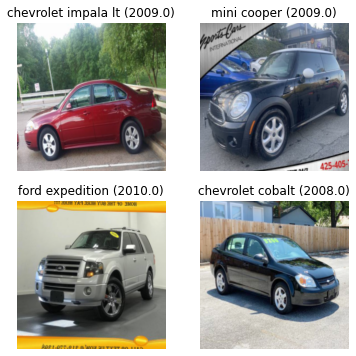

In [0]:
dls.show_batch()

In [0]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()

In [0]:
# learn.validate()

(#2) [7.478991985321045,0.010917030274868011]

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=6.309573450380412e-07)

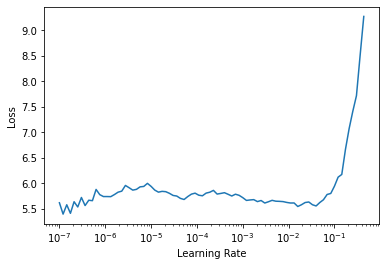

In [0]:
learn.lr_find()

### Fit 1 (20 EPOCHS)

In [0]:
import gc
gc.collect()

21132

In [0]:
learn.fit_one_cycle(20, slice(6e-3))

epoch,train_loss,valid_loss,accuracy,time
0,4.326549,2.647514,0.340611,02:54
1,3.442383,2.407482,0.414847,00:36
2,3.392454,2.661177,0.379913,00:36
3,3.597795,2.712176,0.403930,00:36
4,3.643066,2.490583,0.441048,00:36
5,2.967638,2.019734,0.528384,00:36
6,2.674514,1.976597,0.543668,00:36
7,2.295053,1.726009,0.622271,00:36
8,2.260465,1.423553,0.661572,00:36
9,1.759521,1.516518,0.661572,00:36


epoch,train_loss,valid_loss,accuracy,time


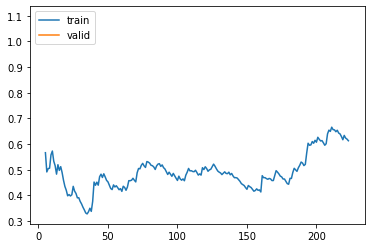

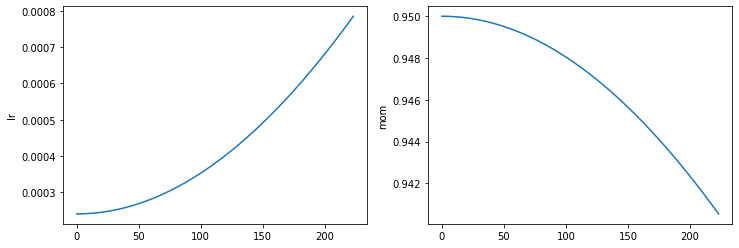

In [0]:
learn.recorder.plot_loss()
learn.recorder.plot_sched()

In [0]:
learn.save(model_path/'resnet50-slice(6e-3)-20epochs-fp16-frozen')

In [0]:
learn = learn.load(model_path/'resnet50-slice(6e-3)-20epochs-fp16-frozen')

SuggestedLRs(lr_min=3.6307807022240014e-06, lr_steep=9.12010818865383e-07)

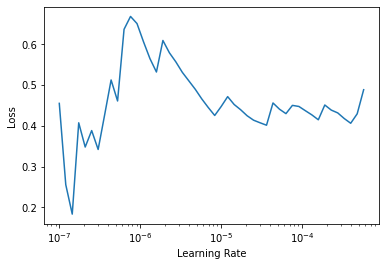

In [0]:
learn.unfreeze()
learn.lr_find()

In [0]:
learn.fit_one_cycle(15, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.503091,1.059060,0.740175,00:45
1,0.508127,1.087616,0.729258,00:45
2,0.542264,1.002292,0.748908,00:45
3,0.727697,1.067443,0.729258,00:45
4,0.537949,1.025415,0.744541,00:45
5,0.628827,1.083793,0.744541,00:45
6,0.548312,1.041736,0.755459,00:45
7,0.456403,0.894673,0.779476,00:45
8,0.444072,0.926856,0.777293,00:45
9,0.338378,0.881061,0.777293,00:47


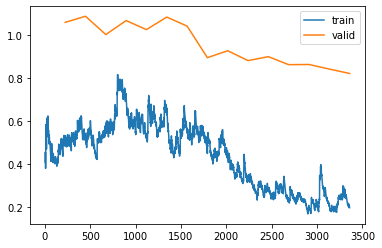

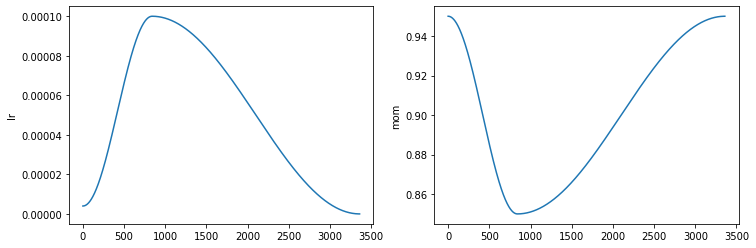

In [0]:
learn.recorder.plot_loss()
learn.recorder.plot_sched()

In [0]:
learn.save(model_path/'resnet50-slice(1e-5, 1e-4)-10epochs-fp16-unfreeze')

In [0]:
learn = learn.load(model_path/'resnet50-slice(1e-5, 1e-4)-10epochs-fp16-unfreeze')

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=9.12010818865383e-07)

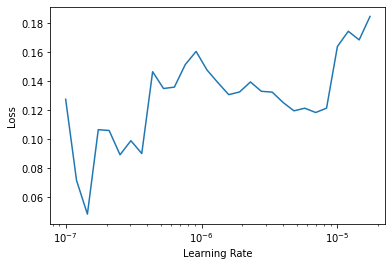

In [0]:
learn.unfreeze()
learn.lr_find()

In [0]:
learn.fit_one_cycle(10, slice(8e-7, 5e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.268342,0.856387,0.781659,00:45
1,0.242947,0.868290,0.770742,00:45
2,0.254860,0.887349,0.772926,00:45
3,0.236570,0.911394,0.777293,00:45
4,0.188399,0.886712,0.790393,00:45
5,0.225792,0.837395,0.779476,00:45
6,0.202082,0.839900,0.794760,00:45
7,0.227380,0.844436,0.779476,00:45
8,0.295409,0.862364,0.783843,00:45
9,0.176487,0.883697,0.775109,00:45


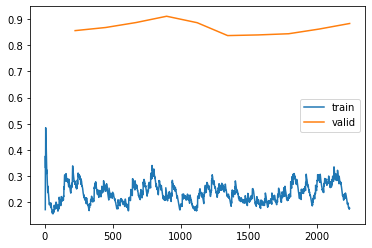

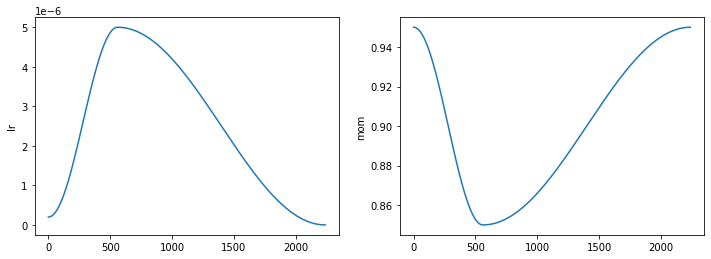

In [0]:
learn.recorder.plot_loss()
learn.recorder.plot_sched()

In [0]:
learn.save(model_path/'resnet50-slice(8e-7, 5e-6)-10epochs-fp16-unfreeze')

In [0]:
learn.validate()

(#2) [0.8836972713470459,0.7751091718673706]

For now, best accuracy is **77.5%** (Can make it better later)

## Extract embedding (V2)

In [0]:
dls_emb = data.dataloaders(data_path, bs=16, shuffle_train=False)

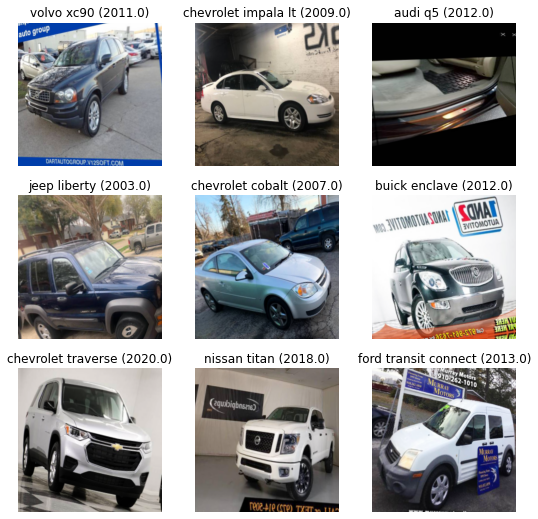

In [0]:
dls_emb.show_batch()

##fin

This is the pretrained resnet50 with concat pool and flatten:

In [0]:
learn_emb2vec = cnn_learner(dls_emb, resnet50, pretrained=True)
learn_emb2vec = learn_emb2vec.load(model_path/'resnet50-slice(8e-7, 5e-6)-10epochs-fp16-unfreeze')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
body = learn_emb2vec.model
# delete the classifier head
del body[-1]
layers = list(body.children())
layers += [AdaptiveConcatPool2d(), Flatten()]  
body = nn.Sequential(*layers)
num_features_model(body)

4096

In [0]:
train_ds= dls_emb.train_ds
valid_ds= dls_emb.valid_ds

In [0]:
%time train_lbl_ids = list(map(lambda x: x[1], train_ds))
%time valid_lbl_ids = list(map(lambda x: x[1], valid_ds))

CPU times: user 7.53 s, sys: 308 ms, total: 7.84 s
Wall time: 9.08 s
CPU times: user 3.94 s, sys: 169 ms, total: 4.1 s
Wall time: 4.71 s


In [0]:
%time train_lbls = list(map(lambda x: dls_emb.vocab[x], train_lbl_ids))
%time valid_lbls = list(map(lambda x: dls_emb.vocab[x], valid_lbl_ids))

CPU times: user 77.2 ms, sys: 0 ns, total: 77.2 ms
Wall time: 78.5 ms
CPU times: user 42.9 ms, sys: 1.02 ms, total: 43.9 ms
Wall time: 41.6 ms


Path to save the important stuff

In [0]:
tmp_path = create_path(model_path/'tmp')

Save the labels and the filenames in the same order as our activations.

In [0]:
def save_texts(dst, list_of_strings):
    list2str = ', '.join(list_of_strings)
    dst.write(list2str)

def loadtxt_str(path):
    strings = path.open(mode='r').read()
    return strings.split(', ')

In [0]:
np.save(str(tmp_path/'trn_lbl.npy'), train_lbls)
np.save(str(tmp_path/'val_lbl.npy'), valid_lbls)
save_texts(tmp_path/'classes.txt', dls_emb.vocab)

In [0]:
np.save(str(tmp_path/'trn_names.npy'), dls_emb.train.items)
np.save(str(tmp_path/'val_names.npy'), dls_emb.valid.items)

We will use bcolz to store our activations in an array that's saved to memory (all won't fit in RAM). Install with 
```
pip install -U bcolz
```

In [0]:
!pip install -U bcolz -q

     |████████████████████████████████| 1.5MB 6.6MB/s 


In [0]:
import bcolz

In [0]:
# To clean-up previous tries
# shutil.rmtree(tmp_path)

Those functions will store the precomputed activations in `tmp_path`.

In [0]:
def precompute_activations_dl(dl, model, path:Path, force:bool=False):
    body.eval()
    if os.path.exists(path) and not force: return
    arr = bcolz.carray(np.zeros((0,4096), np.float32), chunklen=1, mode='w', rootdir=path)
    with torch.no_grad():
        for x,y in progress_bar(dl):
            gc.collect()
            z = body(x)
            arr.append(z.cpu().numpy())
            arr.flush()

In [0]:
def precompute_activations(data, model, path:Path, force:bool=False):
    os.makedirs(path, exist_ok=True)
    precompute_activations_dl(data.train,   model, path/'train', force=force) #Use fix_dl and not train_dl for shuffle=False
    precompute_activations_dl(data.valid, model, path/'valid', force=force)

In [0]:
precompute_activations(dls_emb, body, tmp_path, force=True)

## Fin

load up the classes

In [0]:
classes = loadtxt_str(tmp_path/'classes.txt'); print(L(classes))

(#50) ['acura tlx (2017.0)','audi q5 (2012.0)','buick enclave (2012.0)','chevrolet avalanche (2013.0)','chevrolet camaro (2015.0)','chevrolet cobalt (2007.0)','chevrolet cobalt (2008.0)','chevrolet cruze lt (2018.0)','chevrolet impala (2019.0)','chevrolet impala lt (2009.0)'...]


Then we label each feature map with the word vector of its target.

In [0]:
train_labels = np.load(str(tmp_path/'trn_lbl.npy'))
valid_labels = np.load(str(tmp_path/'val_lbl.npy'))

We use our custom `BcolzItemList` to gather the data:

In [0]:
bcolz.open(tmp_path/'train').shape

(896, 4096)

In [0]:
body.eval()
preds = []
# change all the image embeddings to the appropriate fasttext sized embeddings
with torch.no_grad():
    for x,y in progress_bar(learn_emb2vec.dls.train):
        preds.append(body(x).cpu().numpy())
    for x,y in progress_bar(learn_emb2vec.dls.valid):
        preds.append(body(x).cpu().numpy())

In [0]:
preds = np.concatenate(preds, 0); preds.shape  #(13394, 300)

(1354, 4096)

In [0]:
np.save(str(tmp_path/'preds.npy'), preds)

### Image->image

In [0]:
train_names = np.load(str(tmp_path/'trn_names.npy'), allow_pickle=True)
valid_names = np.load(str(tmp_path/'val_names.npy'), allow_pickle=True)
names = np.concatenate([train_names, valid_names])

In [0]:
preds = np.load(str(tmp_path/'preds.npy'))

### Nearest Neighbor Comparison

In [0]:
!pip install nmslib -q

     |████████████████████████████████| 13.0MB 242kB/s 
     |████████████████████████████████| 296kB 39.7MB/s 


In [0]:
import nmslib

def create_index(a):
    # index = nmslib.init(space='angulardist')
    index = nmslib.init(space='cosinesimil')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [0]:
nn_preds = create_index(preds)

We can also ask for the images with a word vector most similar to another image. This one was downloaded from Google and isn't in Imagenet.

In [0]:
list(classes)

['acura tlx (2017.0)',
 'audi q5 (2012.0)',
 'buick enclave (2012.0)',
 'chevrolet avalanche (2013.0)',
 'chevrolet camaro (2015.0)',
 'chevrolet cobalt (2007.0)',
 'chevrolet cobalt (2008.0)',
 'chevrolet cruze lt (2018.0)',
 'chevrolet impala (2019.0)',
 'chevrolet impala lt (2009.0)',
 'chevrolet impala lt (2010.0)',
 'chevrolet silverado 2500 (2011.0)',
 'chevrolet silverado 2500hd (2013.0)',
 'chevrolet suburban (2012.0)',
 'chevrolet traverse (2020.0)',
 'chrysler 300 (2011.0)',
 'dodge challenger sxt coupe 2d (2018.0)',
 'dodge dakota (2005.0)',
 'dodge durango (2003.0)',
 'fiat 500 (2012.0)',
 'ford expedition (2006.0)',
 'ford expedition (2010.0)',
 'ford f-150 (1979.0)',
 'ford f-150 xlt (2016.0)',
 'ford fiesta (2017.0)',
 'ford transit connect (2013.0)',
 'gmc sierra (2004.0)',
 'gmc yukon (2005.0)',
 'honda civic (2017.0)',
 'honda cr-v (2013.0)',
 'hyundai accent (2017.0)',
 'jeep grand cherokee (2014.0)',
 'jeep grand cherokee laredo (2005.0)',
 'jeep liberty (2003.0)',


In [0]:
# training image: /content/drive/My Drive/flickr-search/dataset/images/7093418375.jpg
# im_path = '/content/drive/My Drive/flickr-search/dataset/images/7093418375.jpg'
im_path = '/content/car2.jpeg'

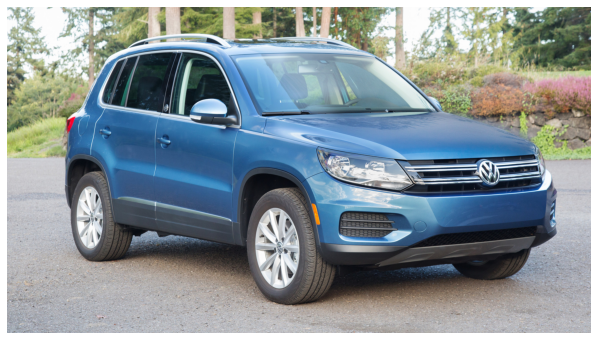

In [0]:
img = TensorImage(PILImage.create(im_path))
img.show(figsize=(12, 6))

In [0]:
dls_test_ = next(iter(dls_emb.test_dl(test_items=im_path)))[0][0]

To get the corresdponding vector, we need to feed it to the pretrained model (`body`, defined at the top) after normalizing it.

In [0]:
with torch.no_grad():
    activs = body.eval()(dls_test_[None].cuda())

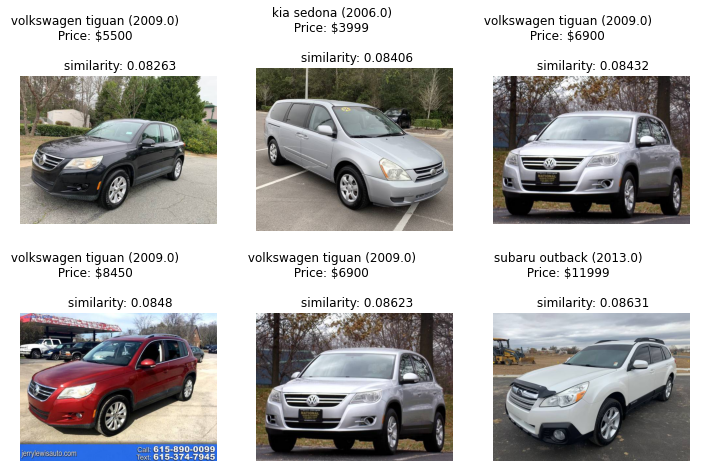

In [0]:
idxs,dists = get_knn(nn_preds, activs.detach().to('cpu'))
_,axs = plt.subplots(2,3,figsize=(12,8))
for i,ax, dist in zip(idxs[:6], axs.flatten(), dists[:6]):
    im_id = Path(names[i]).name[:-4]
    df_ = sample.query(f'id == {im_id}')
    name = df_.product_name.values[0]
    price = df_.price.values[0]
    store = ' ' #df_.url.values[0]
    sim = round(float(dist), 5)
    title = f' {name} \
            \n Price: ${price} \
            \n {store} \
            \n similarity: {sim}'
    TensorImage(PILImage.create(names[i])).show(ax = ax, title=title)